In [685]:

from fitparse import FitFile
from datetime import datetime
from math import sqrt, pi, cos, isnan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from tqdm import tqdm, trange

from itertools import chain
from xml.dom import minidom
#%matplotlib ipympl
R = 6371000 #earth radius [m]


In [110]:
cicle = FitFile('fit_files/2915321598.fit')#cycle
dive = FitFile('fit_files/2918764166.fit')#dive
swim = FitFile('fit_files/2918975969.fit') #swim
swimgpx='fit_files/schwimmen2018-08-09_16-10-45.gpx'


In [539]:
def toDegree(s, t="semicircle"): 
    d=[float('nan')]*len(s)
    if t =="semicircle":   
        s[s == None]=0
        s=np.array(s, dtype=np.uint32)
        d=s*180/2**31
        r[r==0]=np.nan
    elif t == "radian":
        s=np.array(s, dtype=float)
        d=s*180/pi
    return d
def toRadian(s, t="semicircle"): 
    
    r=[float('nan')]*len(s)
    if t =="semicircle":
        s[s == None]=0
        s=np.array(s, dtype=np.uint32)
        r=s*pi/2**31
        r[r==0]=np.nan
    elif t == "degree":
        s=np.array(s, dtype=float)
        r=s*180/2**31
    return r

def toSemicircle(r, t="radian"):
    r=np.array(r, dtype=float)
    s=[0]*len(r)
    if t =="radian":
        s=(r*2**31/pi)
    elif t == "degree":
        s=(r*2**31/180)
    return(s.astype(np.uint32))
    


def trackDev(lat1, lng1,lat2,lng2, t='semicircle'):
    R = 6371000 #earth radius [m]
    if t != "radian":
        lat1=toRadian(lat1, t)
        lng1=toRadian(lng1, t)
        lat2=toRadian(lat2, t)
        lng2=toRadian(lng2, t)
    else:
        lat1=np.array(lat1)
        lng1=np.array(lng1)
        lat2=np.array(lat2)
        lng2=np.array(lng2)
    delta_lat_m=(lat2-lat1) * R
    delta_lng_m=(lng2-lng1) * np.cos(lat2-lat1) * R
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))

def toDeltaMeter(lat, lng, t='semicircle'):
    R = 6371000 #earth radius [m]
    if t != "radian":
        lat=toRadian(lat, t)
        lng=toRadian(lng, t)
    delta_lat=np.diff(lat)
    delta_lng=np.diff(lng)
    delta_lat_m=delta_lat * R
    delta_lng_m=delta_lng * R * np.cos(np.array(lat[:-1]))
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))
    


In [120]:
#READ GPX FILE
def parseGPX(filename):
    gpx=open(filename)
    data={}
    xmldoc = minidom.parse(gpx)
    track = xmldoc.getElementsByTagName('trkpt')
    elevation=xmldoc.getElementsByTagName('ele')
    timestamp=xmldoc.getElementsByTagName('time')
    accuracy=xmldoc.getElementsByTagName('pdop')
    n_track=len(track)
    #PARSING GPX ELEMENT
    data['lng']=[]
    data['lat']=[]
    data['elev']=[]
    data['time']=[]
    data['accuracy']=[]
    for s in range(n_track):
        lng,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
        elev=elevation[s].firstChild.nodeValue
        acc=accuracy[s].firstChild.nodeValue
        data['lng'].append(float(lng))
        data['lat'].append(float(lat))
        data['elev'].append(float(elev))
        data['time'].append(datetime.strptime(timestamp[s].firstChild.nodeValue, "%Y-%m-%dT%H:%M:%S.000Z"))
        data['accuracy'].append(float(acc))
    return data

In [762]:
def parseFit(fitfile, gpxdata=None):
    data={}
    # Get all data messages that are of type record
    for i, record in enumerate(fitfile.get_messages('record')):
        #print("{}___".format(i))
        # Go through all the data entries in this record
        fields=set([])
        for record_data in record:
            # Print the records name and value (and units if it has any)
            fields.add(record_data.name)
            #if i==0: #print first
            if False: #do not print
                if record_data.units:
                    print (" * {}: {} {}".format(record_data.name, record_data.value, record_data.units))
                else:
                    print (" * {}: {}".format(record_data.name, record_data.value))
            if record_data.name not in data:
                data[record_data.name]=[None] * i
            data[record_data.name].append(record_data.value)
        for missing in set(data.keys()).difference(fields):
            data[missing].append(None)
        
    for n in data.keys():
        if isinstance(data[n][0], tuple):
            data[n]=list(chain.from_iterable(data[n]))
        
        data[n]=np.array(data[n])#, dtype=np.float)
        dty=np.array([type(e) for i,e in enumerate(data[n])])
        if(data[n].dtype == 'O' and sum(dty ==int)>10):
            data[n][dty != int]=0
            data[n]=data[n].astype(int)
        if(data[n].dtype == 'O' and sum(dty ==float)>10):
            data[n][dty != float]=float('nan')
            data[n]=data[n].astype(float)
    mWS=9807 #Pa
    amb_pressure=np.nanmedian(data['pressure'][0:150])
    #amb_pressure=100000
    data['depth']=(amb_pressure-data['pressure'])/mWS*100
    data['depth'][np.isnan(data['depth'])]=-100
    data['depth'][data['depth']>0]=0

    if gpxdata is not None:
        gpxdata['time']=np.array(gpxdata['time'])
        data['true_lat']=[]
        data['true_lng']=[]
        for i in range(len(data['timestamp'])) :
            dt=[(data['timestamp'][i]-t).total_seconds() for j,t in enumerate(gpxdata['time'])]
            matchedI=np.argmin(np.abs(dt))
            data['true_lat'].append(toSemicircle([gpxdata['lat'][matchedI]], "degree")[0])
            data['true_lng'].append(toSemicircle([gpxdata['lng'][matchedI]], "degree")[0])
        data['true_lat']=np.array(data['true_lat'])
        data['true_lng']=np.array(data['true_lng'])
        
        print(str(type(data['position_lat']))+"--"+str(type(data['true_lat'])))
        error= trackDev(data['position_lat'], data['position_long'], data['true_lat'], data['true_lng'], "semicircle")
        data['error_abs']=np.array(error['dist'])
        data['error_lat']=np.array(error['delta_lat'])
        data['error_lng']=np.array(error['delta_lng'])
        
        
        
        
    return data

In [727]:
def plotData(data, start, end):
    t = np.arange(0., len(data['gps_time']), 1/15)
    lim=(start,end)
    idx=data['gps_time']
    idx[np.isnan(idx)]=0
    idx=(np.arange(0, len(data['gps_time']))*15+idx).astype(int)
    gps_time=t[idx]
    #print(str(gps_time))
    col=np.array(["green", "red", "gray"])
    depth=data['depth']
    
    gps_underwater=(depth[idx.astype(int)]< - 5).astype(int)
    gps_underwater[np.isnan(data['position_lat'])]=2
    cols=col[gps_underwater]

    ax = plt.subplot(4, 1, 1)
    ax.plot(t, data['accel_X'], 'r--', t, data['accel_Y'], 'b--', t,data['accel_Z'], 'g--')
    plt.xlim(lim[0],lim[1])
    drange=[np.nanmin(np.array([data['accel_X'], data['accel_Y'], data['accel_Z']])), 
           np.nanmax(np.array([data['accel_X'], data['accel_Y'], data['accel_Z']]))]
    ax.vlines(x=gps_time, ymin=drange[0], ymax=drange[1], color=cols, linestyle='--')
    #ax.grid(color='grey', linestyle='-', linewidth=1)


    ax = plt.subplot(4, 1, 2)
    ax.plot(t, data['mag_X'], 'r--', t, data['mag_Y'], 'b--', t,data['mag_Z'], 'g--')
    plt.xlim(lim[0],lim[1])
    drange=[np.nanmin(np.array([data['mag_X'], data['mag_Y'], data['mag_Z']])), 
           np.nanmax(np.array([data['mag_X'], data['mag_Y'], data['mag_Z']]))]
    ax.vlines(x=gps_time, ymin=drange[0], ymax=drange[1], color=cols, linestyle='--')
    #ax.grid(color='grey', linestyle='-', linewidth=1)


    ax = plt.subplot(4, 1, 3)
    ax.plot(t,depth , '--' )
    plt.xlim(lim[0],lim[1])
    drange=[np.nanmin(depth), 
           np.nanmax(depth)]
    ax.vlines(x=gps_time, ymin=drange[0], ymax=drange[1], color=cols, linestyle='--')
    #ax.grid(color='grey', linestyle='-', linewidth=1)

    if 'true_lng' in data.keys():
        dev=trackDev(data['position_lat'], data['position_long'], data['true_lat'], data['true_lng'])
        ax = plt.subplot(4, 1, 4)
        
        ax.plot(gps_time,dev['dist'] , '--' )
        ax.plot(gps_time,dev['delta_lat'] , 'g--' )
        ax.plot(gps_time,dev['delta_lng'] , 'r--' )
        plt.xlim(lim[0],lim[1])
        

    ax.figure.set_size_inches(20,10)
    plt.show()


In [778]:
def plotPos(data,gpx=None, start=0, end=10, garmin=True, app=True, phone=True , drawPoints=False, colBy="underwater"):
    t = np.arange(0., len(data['gps_time']), 1/15)
    idx=data['gps_time']
    idx[np.isnan(idx)]=0
    idx=(np.arange(0, len(data['gps_time']))*15+idx).astype(int)    
    gps_time=t[idx]
    start, end=(np.argmax(gps_time > start),np.argmax(gps_time>end))
    if end == 0:
        end=len(t)
    
    #print(str(gps_time))
    cols='b'
    if(colBy =="underwater"):
        depth=data['depth']
        gps_underwater=(depth[idx.astype(int)]< - 5).astype(int)
        gps_underwater[np.isnan(data['position_lat'])]=2
        cols=gps_underwater
        cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "red", "gray"], N=3)
    elif colBy =="error" and 'error_abs' in data.keys():
        cols=data['error_abs']
        cols[np.isnan(cols)]=np.nan
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","red"], N=100)
    else:
        cols=np.array([1])
        cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "black"], N=1)
    minc=np.nanmin(cols)
    maxc=np.nanmax(cols)    
    if garmin:
        track=toDeltaMeter(data['position_lat'],data['position_long'], "semicircle" )
        plt.plot(  np.nancumsum(track['delta_lng'])[start:end], np.nancumsum(track['delta_lat'])[start:end],c='tab:brown', linestyle='--')
        if drawPoints:
            plt.scatter(  np.nancumsum(track['delta_lng'])[start:end], np.nancumsum(track['delta_lat'])[start:end], s=10,c=list(cols)[start:end], cmap=cmap, vmin=minc, vmax=maxc)
    if app:
        track=toDeltaMeter(data['gps_lat'],data['gps_lng'], "semicircle" )
        plt.plot(  np.nancumsum(track['delta_lng'])[start:end], np.nancumsum(track['delta_lat'])[start:end],c='tab:orange', linestyle='--')
        if drawPoints:
            plt.scatter(  np.nancumsum(track['delta_lng'])[start:end], np.nancumsum(track['delta_lat'])[start:end], s=10,c=list(cols)[start:end], cmap=cmap, vmin=minc, vmax=maxc)
    if phone:
        if 'true_lat' in data.keys():
            track=toDeltaMeter(data['true_lat'],data['true_lng'], "semicircle" )
            plt.plot(  np.nancumsum(track['delta_lng'])[start:end], np.nancumsum(track['delta_lat'])[start:end],c='tab:blue', linestyle='--')
        

        
    plt.axis('equal')
    plt.show()

In [729]:
def runningMean(x, N):
    return np.convolve(x, np.ones((N,))/N, 'same')


# Observations

In [763]:
#load data
diveData=parseFit(dive)
swimGpxData=parseGPX(swimgpx)
swimData=parseFit(swim, swimGpxData)


<class 'numpy.ndarray'>--<class 'numpy.ndarray'>


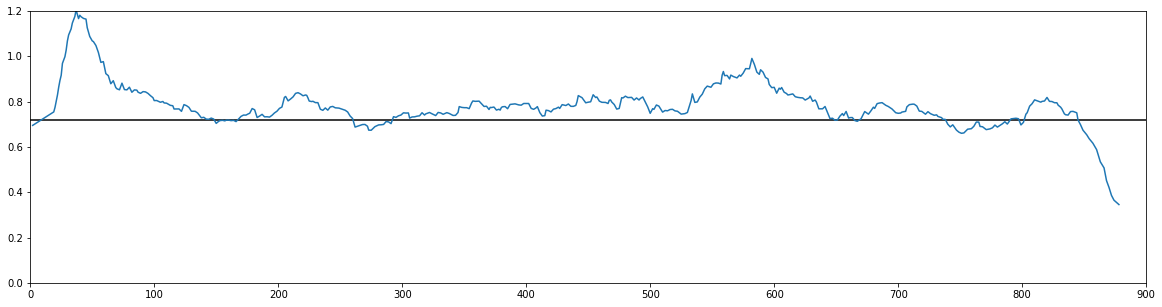

In [731]:
lng1=swimData['position_long']
lat1=swimData['position_lat']
lng2=swimData['gps_lng']
lat2=swimData['gps_lat']
lng3=swimData['true_lng']
lat3=swimData['true_lat']
dif_garmin=trackDev(lat1, lng1, lat3, lng3)
#1 and 2 are between 17 cm and 1 meter off (strange)
track=toDeltaMeter(lat3, lng3)
moved=list(np.logical_or(np.diff(lat3)!=0 , np.diff(lng3)!=0))
time=np.arange(len(moved))[moved]
dt=[1]+list(np.diff(time))
dist=list(track['dist'][moved])
speed=[dist[i]/dt[i] for i in range(len(dist))]
plt.hlines([np.nanmedian(speed)], lim[0],lim[1])
plt.plot(time, runningMean(speed,30))
lim=(0,900)
plt.xlim(lim[0],lim[1])
plt.ylim(0,1.2)
fig = plt.gcf() 
fig.set_size_inches(20,5)

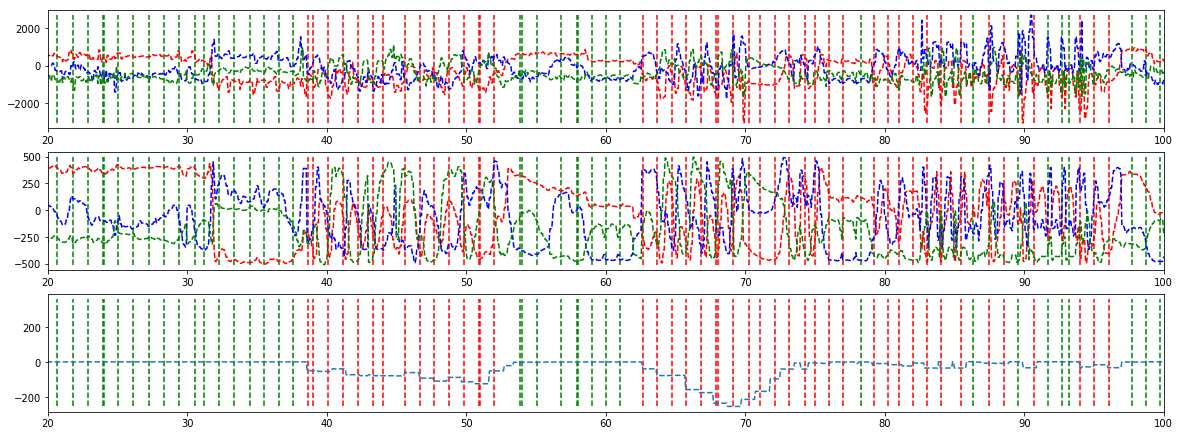

In [586]:
plotData(diveData,start=20,end=100)

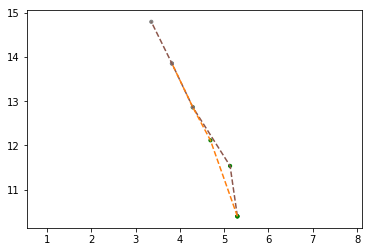

In [774]:
plotPos(diveData, start=35, end=40, drawPoints=True)

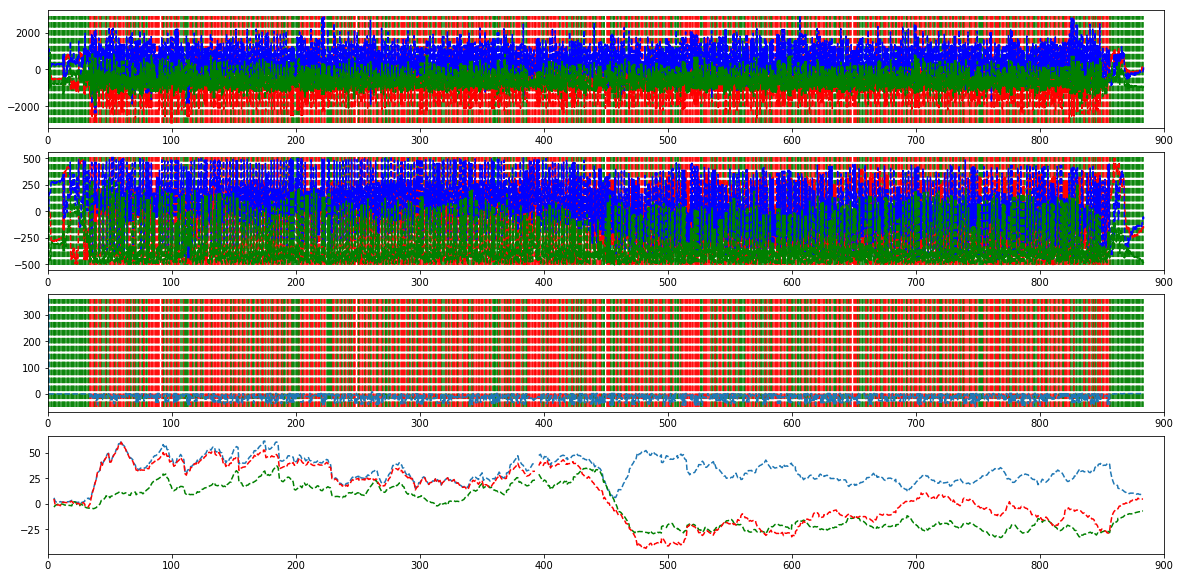

In [592]:
plotData(swimData,start=0,end=900)

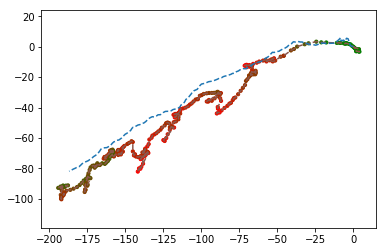

In [784]:
plotPos(swimData,start=0,end=300, drawPoints=True,app=False, colBy="error")

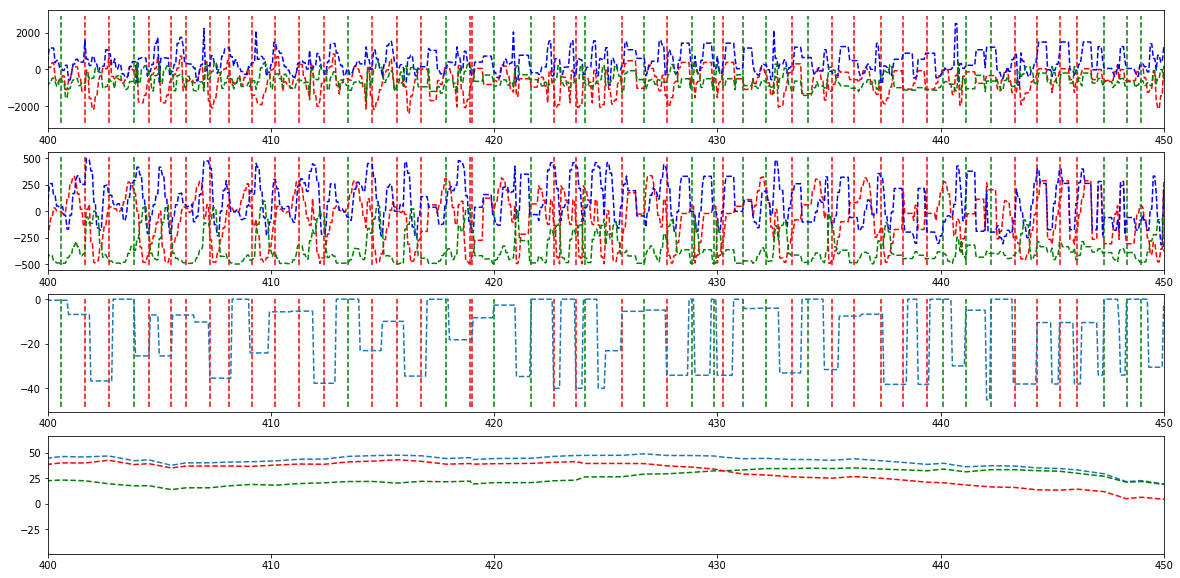

In [775]:
plotData(swimData,start=400,end=450)

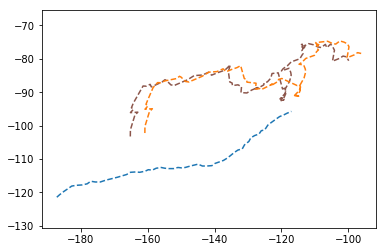

In [776]:
plotPos(swimData,start=550,end=650)

In [138]:

idx=(np.arange(0, len(swimData['gps_time']))*15+swimData['gps_time']).astype(int)

array([-9223372036854775808,                   15,                   41,
                         58,                   74,                   76,
                         91,                  106,                  122,
                        138,                  153,                  169,
                        185,                  202,                  210,
                        231,                  246,                  261,
                        276,                  291,                  307,
                        324,                  340,                  356,
                        373,                  389,                  401,
                        417,                  432,                  449,
                        450,                  467,                  493,
                        498,                  511,                  528,
                        544,                  555,                  572,
                        588,                  600, 

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [126]:
depth[idx.astype(int)]< -1

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [127]:
["red", "blue"][(depth[idx.astype(int)]< -1).astype(int)]

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [128]:
(depth[idx.astype(int)]< -1).astype(int)

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485